In [1]:
import numpy as np
from scipy.special import erfi
from bertram0_functions import w1, w2
import pandas as pd
def expected_return(a, m, c, alpha, eta, rf=0):
    return alpha*(m-a-c-rf) / np.pi / \
        (erfi(m*np.sqrt(alpha)/eta)-erfi(a*np.sqrt(alpha)/eta))

def variance(a, m, c, alpha, eta):
    z_m = m * np.sqrt(2*alpha) / eta
    z_a = a * np.sqrt(2*alpha) / eta
    return alpha*((m-a-c)**2) * (w1(z_m) - w1(z_a) - w2(z_m) + w2(z_a)) / \
        ((np.pi**3) * (erfi(z_m/np.sqrt(2))-erfi(z_a/np.sqrt(2)))**3)

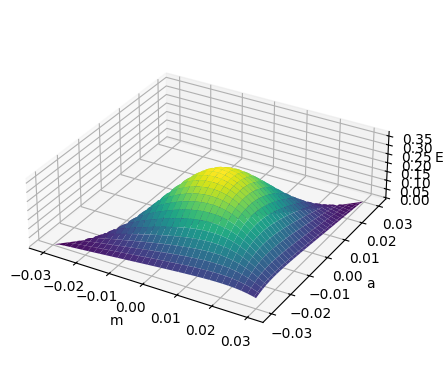

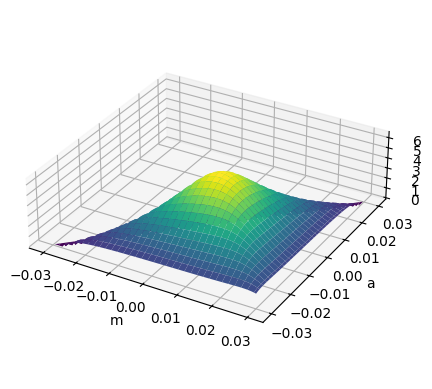

In [ ]:
#Analytical results
alpha = 100    #mean reversion speed
eta = 0.15     #volatility
# Eta의 직관적인 의미: 
#   - \eta * dW_t 라는 부분에서  = \eta * \sqrt{dt} * \epsilon_t
#   - 하루로 보면 1% 정도의 변동성. 

c = 0.001      #cost
rf = 0.002
mm = np.linspace(-0.03, 0.03, 101)
aa = np.linspace(-0.03, 0.03, 101)
er_list = np.ones((len(aa), len(mm))) * np.nan
sr_list = np.ones((len(aa), len(mm))) * np.nan
for i, a in enumerate(aa):
    for j, m in enumerate(mm):
        if m>a:
            er = expected_return(a, m, c, alpha, eta)
            exr = expected_return(a, m, c, alpha, eta, rf)
            var = variance(a, m, c, alpha, eta)
            er_list[i, j] = er
            sr_list[i, j] = exr/np.sqrt(var)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mm2, aa2 = np.meshgrid(mm, aa)
ax.plot_surface(mm2, aa2, np.maximum(er_list, 0), cmap="viridis")
ax.set_box_aspect([1, 1, 0.3])
ax.set_xlabel('m')
ax.set_ylabel('a')
ax.set_zlabel('E[R]')
plt.show()



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mm2, aa2, np.maximum(sr_list, 0), cmap="viridis")
ax.set_box_aspect([1, 1, 0.3])
ax.set_xlabel('m')
ax.set_ylabel('a')
ax.set_zlabel('SR')
plt.show()

최적해. 기대수익 최대화 전략의 수식을 구현하신 것. 

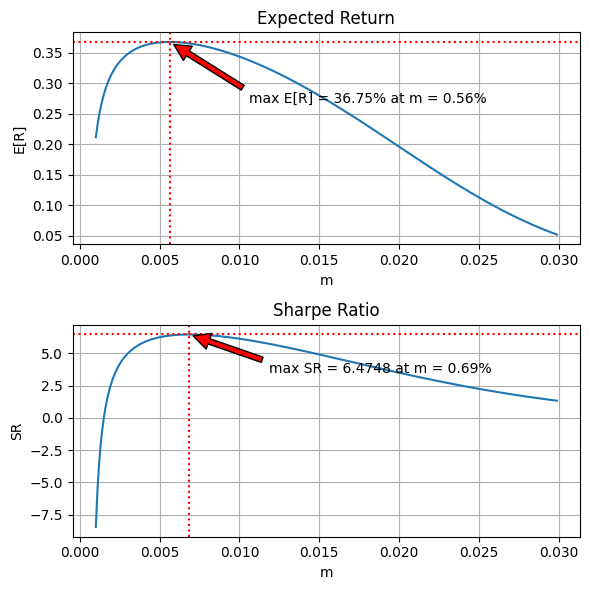

m = 0.56%, max_ER = 36.75%
m = 0.69%, max_SR = 6.4748


In [ ]:

from scipy.optimize import root_scalar, minimize, fsolve
def fun(a, alpha, eta, c):
    return np.exp((alpha*a**2)/(eta**2)) * (2*a+c) - eta*np.sqrt(np.pi/alpha) * erfi(a*np.sqrt(alpha)/eta)

def max_er(a, alpha, eta, c):
    return alpha*(2*a+c) / (2*np.pi*erfi(a*np.sqrt(alpha)/eta))


root = root_scalar(fun, args=(alpha, eta, c, ), x0=-0.01)
# root = fsolve(fun, args=(alpha, eta, c, ), x0=-0.01) # legacy
maxER = max_er(root.root, alpha, eta, c)



def sr(a, c, rf, alpha, eta):
    s = -(2*a+c+rf)*np.sqrt(alpha*np.pi*erfi(-a*np.sqrt(alpha)/eta))
    s /= np.sqrt((2*a+c)**2 * (-w1(a*np.sqrt(2*alpha)/eta)+w2(a*np.sqrt(2*alpha)/eta)))
    return -s

res = minimize(sr, x0=np.array([-0.001]), args=(c, rf, alpha, eta), method='Nelder-Mead')
sol = -res.x[0]
sol_sr = -sr(res.x[0], c, rf, alpha, eta)


mm = np.arange(c, 0.03, 0.0001)
er_list = np.ones(len(mm)) * np.nan
sr_list = np.ones(len(mm)) * np.nan
for j, m in enumerate(mm):
    er = expected_return(-m, m, c, alpha, eta)
    exr = expected_return(-m, m, c, alpha, eta, rf)
    var = variance(-m, m, c, alpha, eta)
    er_list[j] = er
    sr_list[j] = exr/np.sqrt(var)

fig, ax = plt.subplots(2,1,figsize=(6,6))
ax[0].plot(mm, er_list)
ax[0].grid()
ax[0].axvline(-root.root, color='red', linestyle=':')
ax[0].axhline(maxER, color='red', linestyle=':')
ax[0].set_title('Expected Return')
ax[0].set_xlabel('m')
ax[0].set_ylabel('E[R]')
ax[0].annotate(f'max E[R] = {maxER:.2%} at m = {-root.root:.2%}', xy=(-root.root, maxER), \
                xytext=(-root.root+0.005, maxER-0.1), arrowprops=dict(facecolor='red', shrink=0.05))

ax[1].plot(mm, sr_list)
ax[1].grid()
ax[1].axvline(-res.x, color='red', linestyle=':')
ax[1].axhline(-sr(res.x, c, rf, alpha, eta), color='red', linestyle=':')
ax[1].set_title('Sharpe Ratio')
ax[1].set_xlabel('m')
ax[1].set_ylabel('SR')
ax[1].annotate(f'max SR = {sol_sr:.4f} at m = {sol:.2%}', xy=(sol, sol_sr), \
                xytext=(sol+0.005, sol_sr-3), arrowprops=dict(facecolor='red', shrink=0.05))
fig.tight_layout()
plt.show()

print(f"m = {-root.root:.2%}, max_ER = {maxER:.2%}")
print(f"m = {sol:.2%}, max_SR = {sol_sr:.4f}")